In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# 随机种子
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch: {torch.__version__}")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch: 2.5.1+cu124
Device: cuda
GPU: NVIDIA A100-PCIE-40GB


## 加载数据

In [2]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

train_df['Timestamp'] = pd.to_datetime(train_df['Timestamp'])
test_df['Timestamp'] = pd.to_datetime(test_df['Timestamp'])

train_df = train_df.sort_values('Timestamp').reset_index(drop=True)
test_df = test_df.sort_values('Timestamp').reset_index(drop=True)

print(f"训练集: {train_df.shape}")
print(f"测试集: {test_df.shape}")
print(f"\nTarget统计:")
print(train_df['Target'].describe())

训练集: (484202, 7)
测试集: (2881, 6)

Target统计:
count    484202.000000
mean          0.000021
std           0.005454
min          -0.276799
25%          -0.001275
50%           0.000000
75%           0.001384
max           0.598299
Name: Target, dtype: float64


## 特征工程

In [3]:
def create_features(df):
    """创建特征"""
    df = df.copy()
    
    # 收益率
    df['returns'] = df['Close'].pct_change()
    df['log_returns'] = np.log(df['Close'] / df['Close'].shift(1))
    
    # 移动平均
    for w in [5, 10, 20, 50]:
        df[f'ma_{w}'] = df['Close'].rolling(w).mean()
        df[f'ma_ratio_{w}'] = df['Close'] / df[f'ma_{w}']
    
    # 波动率
    df['volatility_5'] = df['returns'].rolling(5).std()
    df['volatility_10'] = df['returns'].rolling(10).std()
    df['volatility_20'] = df['returns'].rolling(20).std()
    
    # RSI
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    df['rsi'] = 100 - 100 / (1 + gain / (loss + 1e-10))
    
    # MACD
    ema12 = df['Close'].ewm(span=12).mean()
    ema26 = df['Close'].ewm(span=26).mean()
    df['macd'] = ema12 - ema26
    df['macd_signal'] = df['macd'].ewm(span=9).mean()
    
    # 价格比率
    df['high_low_ratio'] = df['High'] / (df['Low'] + 1e-10)
    df['close_open_ratio'] = df['Close'] / (df['Open'] + 1e-10)
    
    # 成交量
    df['volume_ma_10'] = df['Volume'].rolling(10).mean()
    df['volume_ratio'] = df['Volume'] / (df['volume_ma_10'] + 1e-10)
    
    # 滞后特征
    for lag in [1, 2, 3, 5, 10]:
        df[f'returns_lag_{lag}'] = df['returns'].shift(lag)
        df[f'close_lag_{lag}'] = df['Close'].shift(lag)
    
    return df

train_featured = create_features(train_df)
test_featured = create_features(test_df)

print(f"特征后列数: {train_featured.shape[1]}")

特征后列数: 37


In [4]:
# 选择特征列
feature_cols = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'returns', 'log_returns',
    'ma_ratio_5', 'ma_ratio_10', 'ma_ratio_20', 'ma_ratio_50',
    'volatility_5', 'volatility_10', 'volatility_20',
    'rsi', 'macd', 'macd_signal',
    'high_low_ratio', 'close_open_ratio', 'volume_ratio',
    'returns_lag_1', 'returns_lag_2', 'returns_lag_3', 'returns_lag_5', 'returns_lag_10'
]

print(f"特征数量: {len(feature_cols)}")

特征数量: 25


## 数据预处理

In [5]:
# 清洗数据
train_clean = train_featured.dropna().reset_index(drop=True)
print(f"清洗后: {train_clean.shape}")

# 特征标准化
feature_scaler = StandardScaler()
X = feature_scaler.fit_transform(train_clean[feature_cols])

# Target 使用 MinMaxScaler (论文中提到的)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
y = target_scaler.fit_transform(train_clean[['Target']]).flatten()

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"y range: [{y.min():.4f}, {y.max():.4f}]")

清洗后: (484153, 37)
X shape: (484153, 25)
y shape: (484153,)
y range: [-1.0000, 1.0000]
X shape: (484153, 25)
y shape: (484153,)
y range: [-1.0000, 1.0000]


In [6]:
# 创建滑动窗口序列 (论文使用 window=6)
WINDOW_SIZE = 6

def create_window_data(X, y, window_size):
    """将数据转换为窗口格式用于MLP"""
    X_windowed = []
    y_windowed = []
    
    for i in range(window_size, len(X)):
        # 将窗口内的所有特征展平
        window_features = X[i-window_size:i].flatten()
        X_windowed.append(window_features)
        y_windowed.append(y[i])
    
    return np.array(X_windowed), np.array(y_windowed)

X_windowed, y_windowed = create_window_data(X, y, WINDOW_SIZE)
print(f"窗口化后 X: {X_windowed.shape}")
print(f"窗口化后 y: {y_windowed.shape}")
print(f"每个样本特征数: {X_windowed.shape[1]}")

窗口化后 X: (484147, 150)
窗口化后 y: (484147,)
每个样本特征数: 150


In [7]:
# 时序分割 (论文使用 70:30)
train_size = int(len(X_windowed) * 0.7)

X_train = X_windowed[:train_size]
y_train = y_windowed[:train_size]
X_val = X_windowed[train_size:]
y_val = y_windowed[train_size:]

print(f"训练集: {X_train.shape}")
print(f"验证集: {X_val.shape}")

# 转为 Tensor
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train).unsqueeze(1)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.FloatTensor(y_val).unsqueeze(1)

# DataLoader
BATCH_SIZE = 128
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nBatches - Train: {len(train_loader)}, Val: {len(val_loader)}")

训练集: (338902, 150)
验证集: (145245, 150)

Batches - Train: 2648, Val: 1135


## 超参数调优

使用网格搜索优化以下参数:
- 窗口大小 (Window Size)
- 隐藏层结构
- Dropout 比例
- 学习率

In [8]:
# 超参数搜索空间
param_grid = {
    'window_size': [6, 10, 15, 20],
    'hidden_sizes': [
        [512, 256, 128],
        [256, 128, 64],
        [512, 256, 128, 64],
        [256, 128, 64, 32],
    ],
    'dropout': [0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'batch_size': [64, 128, 256],
}

print("超参数搜索空间:")
for k, v in param_grid.items():
    print(f"  {k}: {v}")

超参数搜索空间:
  window_size: [6, 10, 15, 20]
  hidden_sizes: [[512, 256, 128], [256, 128, 64], [512, 256, 128, 64], [256, 128, 64, 32]]
  dropout: [0.1, 0.2, 0.3]
  learning_rate: [0.001, 0.0005, 0.0001]
  batch_size: [64, 128, 256]


## 定义 MLP 模型

论文架构: Input -> 3 Hidden Layers -> Output

In [9]:
class CryptoMLP(nn.Module):
    """多层感知器 (DNN) 用于加密货币预测
    
    基于论文架构:
    - Input: (window_size * n_features)
    - 3个隐藏层，使用 ReLU 激活
    - Output: 1 (预测值)
    """
    def __init__(self, input_size, hidden_sizes=[256, 128, 64], dropout=0.2):
        super(CryptoMLP, self).__init__()
        
        layers = []
        prev_size = input_size
        
        # 隐藏层
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_size = hidden_size
        
        # 输出层
        layers.append(nn.Linear(prev_size, 1))
        
        self.network = nn.Sequential(*layers)
        
        # 权重初始化
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        return self.network(x)

# 创建模型
input_size = X_train.shape[1]  # window_size * n_features
model = CryptoMLP(
    input_size=input_size,
    hidden_sizes=[256, 128, 64],
    dropout=0.2
).to(device)

print(model)
print(f"\n参数量: {sum(p.numel() for p in model.parameters()):,}")

CryptoMLP(
  (network): Sequential(
    (0): Linear(in_features=150, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=64, out_features=1, bias=True)
  )
)

参数量: 80,769


In [10]:
from itertools import product
import time

def train_and_evaluate(X, y, window_size, hidden_sizes, dropout, lr, batch_size, epochs=50, patience=10):
    """训练并评估模型，返回验证集相关系数"""
    set_seed(42)
    
    # 创建窗口数据
    X_w, y_w = create_window_data(X, y, window_size)
    
    # 分割
    train_size = int(len(X_w) * 0.7)
    X_tr, y_tr = X_w[:train_size], y_w[:train_size]
    X_va, y_va = X_w[train_size:], y_w[train_size:]
    
    # Tensor
    X_tr_t = torch.FloatTensor(X_tr)
    y_tr_t = torch.FloatTensor(y_tr).unsqueeze(1)
    X_va_t = torch.FloatTensor(X_va)
    y_va_t = torch.FloatTensor(y_va).unsqueeze(1)
    
    # DataLoader
    train_ds = TensorDataset(X_tr_t, y_tr_t)
    val_ds = TensorDataset(X_va_t, y_va_t)
    train_ld = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_ld = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    
    # 模型
    model = CryptoMLP(
        input_size=X_tr.shape[1],
        hidden_sizes=hidden_sizes,
        dropout=dropout
    ).to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    best_val_loss = float('inf')
    best_model_state = None
    patience_cnt = 0
    
    for epoch in range(epochs):
        # 训练
        model.train()
        for X_b, y_b in train_ld:
            X_b, y_b = X_b.to(device), y_b.to(device)
            optimizer.zero_grad()
            loss = criterion(model(X_b), y_b)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        scheduler.step()
        
        # 验证
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_b, y_b in val_ld:
                X_b, y_b = X_b.to(device), y_b.to(device)
                val_loss += criterion(model(X_b), y_b).item()
        val_loss /= len(val_ld)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_cnt = 0
        else:
            patience_cnt += 1
            if patience_cnt >= patience:
                break
    
    # 用最佳模型计算相关系数
    model.load_state_dict(best_model_state)
    model.eval()
    with torch.no_grad():
        val_pred = model(X_va_t.to(device)).cpu().numpy().flatten()
    
    corr = np.corrcoef(y_va, val_pred)[0, 1]
    pred_std = np.std(val_pred)
    
    # 清理 GPU 内存
    del model, optimizer
    torch.cuda.empty_cache()
    
    return corr, pred_std, best_val_loss

print("训练函数已定义")

训练函数已定义


In [12]:
# 跳过超参数搜索，使用预设的经验参数进行快速试验
print("ℹ️ 跳过自动搜索，使用预设参数进行快速试验...")

# 预设的"较好"参数 (基于经验)
# Window Size: 10 (捕捉短期趋势)
# Hidden Sizes: [256, 128, 64] (经典结构)
# Dropout: 0.2 (防止过拟合)
# Learning Rate: 0.001 (标准)
# Batch Size: 64 (平衡速度和稳定性)

manual_best_params = {
    'window_size': 10,
    'hidden_sizes': '[256, 128, 64]',
    'dropout': 0.2,
    'learning_rate': 0.001,
    'batch_size': 64,
    'correlation': 0.0, # 占位符，不影响后续流程
    'pred_std': 0.0,    # 占位符
    'val_loss': 0.0,    # 占位符
    'time': 0.0         # 占位符
}

# 构造 results 列表，以便兼容后续代码
results = [manual_best_params]

print(f"已设置手动参数: {manual_best_params}")
print("\n✅ 参数设置完成，请继续执行后续单元格进行训练")

ℹ️ 跳过自动搜索，使用预设参数进行快速试验...
已设置手动参数: {'window_size': 10, 'hidden_sizes': '[256, 128, 64]', 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'correlation': 0.0, 'pred_std': 0.0, 'val_loss': 0.0, 'time': 0.0}

✅ 参数设置完成，请继续执行后续单元格进行训练


In [13]:
# 查看最佳参数
if not results:
    print("❌ No results found. Training failed for all combinations.")
else:
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('correlation', ascending=False)

    print("=" * 80)
    print("超参数搜索结果 (按相关系数排序)")
    print("=" * 80)
    print(results_df.to_string(index=False))

    print("\n" + "=" * 80)
    print("最佳参数:")
    print("=" * 80)
    best_params = results_df.iloc[0]
    print(f"Window Size: {best_params['window_size']}")
    print(f"Hidden Sizes: {best_params['hidden_sizes']}")
    print(f"Dropout: {best_params['dropout']}")
    print(f"Learning Rate: {best_params['learning_rate']}")
    print(f"Batch Size: {best_params['batch_size']}")
    print(f"Correlation: {best_params['correlation']:.4f}")
    print(f"Pred Std: {best_params['pred_std']:.4f}")

超参数搜索结果 (按相关系数排序)
 window_size   hidden_sizes  dropout  learning_rate  batch_size  correlation  pred_std  val_loss  time
          10 [256, 128, 64]      0.2          0.001          64          0.0       0.0       0.0   0.0

最佳参数:
Window Size: 10
Hidden Sizes: [256, 128, 64]
Dropout: 0.2
Learning Rate: 0.001
Batch Size: 64
Correlation: 0.0000
Pred Std: 0.0000


## 使用最佳参数训练最终模型

In [14]:
# 提取最佳参数
BEST_WINDOW_SIZE = int(best_params['window_size'])
BEST_HIDDEN_SIZES = eval(best_params['hidden_sizes'])  # 从字符串转回列表
BEST_DROPOUT = float(best_params['dropout'])
BEST_LR = float(best_params['learning_rate'])
BEST_BATCH_SIZE = int(best_params['batch_size'])

print("最佳超参数:")
print(f"  WINDOW_SIZE = {BEST_WINDOW_SIZE}")
print(f"  HIDDEN_SIZES = {BEST_HIDDEN_SIZES}")
print(f"  DROPOUT = {BEST_DROPOUT}")
print(f"  LEARNING_RATE = {BEST_LR}")
print(f"  BATCH_SIZE = {BEST_BATCH_SIZE}")

最佳超参数:
  WINDOW_SIZE = 10
  HIDDEN_SIZES = [256, 128, 64]
  DROPOUT = 0.2
  LEARNING_RATE = 0.001
  BATCH_SIZE = 64


In [15]:
# 使用最佳参数重新创建数据
set_seed(42)

X_windowed_best, y_windowed_best = create_window_data(X, y, BEST_WINDOW_SIZE)

train_size = int(len(X_windowed_best) * 0.8)  # 使用更多数据训练

X_train = X_windowed_best[:train_size]
y_train = y_windowed_best[:train_size]
X_val = X_windowed_best[train_size:]
y_val = y_windowed_best[train_size:]

X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train).unsqueeze(1)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.FloatTensor(y_val).unsqueeze(1)

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_loader = DataLoader(train_dataset, batch_size=BEST_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BEST_BATCH_SIZE, shuffle=False)

print(f"训练集: {X_train.shape}")
print(f"验证集: {X_val.shape}")

训练集: (387314, 250)
验证集: (96829, 250)


In [18]:
# 创建最终模型
model_final = CryptoMLP(
    input_size=X_train.shape[1],
    hidden_sizes=BEST_HIDDEN_SIZES,
    dropout=BEST_DROPOUT
).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model_final.parameters(), lr=BEST_LR, weight_decay=1e-4)

EPOCHS = 15
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=30, T_mult=2)

print(model_final)
print(f"\n参数量: {sum(p.numel() for p in model_final.parameters()):,}")

CryptoMLP(
  (network): Sequential(
    (0): Linear(in_features=250, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=64, out_features=1, bias=True)
  )
)

参数量: 106,369


In [19]:
# 训练最终模型
best_val_loss = float('inf')
patience = 2
patience_counter = 0

train_losses = []
val_losses = []

print("开始训练最终模型...\n")

for epoch in range(EPOCHS):
    # 训练
    model_final.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        output = model_final(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_final.parameters(), 1.0)
        optimizer.step()
        
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    scheduler.step()
    
    # 验证
    model_final.eval()
    val_loss = 0
    val_preds = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model_final(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()
            val_preds.extend(output.cpu().numpy().flatten())
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    pred_std = np.std(val_preds)
    corr = np.corrcoef(y_val, val_preds)[0, 1]
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{EPOCHS} - Train: {train_loss:.6f} - Val: {val_loss:.6f} - Corr: {corr:.4f} - Std: {pred_std:.4f} - LR: {current_lr:.6f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model_final.state_dict(), '../models/dnn_best.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

print("\n✅ 训练完成!")

开始训练最终模型...

Epoch 1/15 - Train: 0.008262 - Val: 0.000042 - Corr: 0.0018 - Std: 0.0022 - LR: 0.000997
Epoch 1/15 - Train: 0.008262 - Val: 0.000042 - Corr: 0.0018 - Std: 0.0022 - LR: 0.000997

Early stopping at epoch 5

✅ 训练完成!

Early stopping at epoch 5

✅ 训练完成!


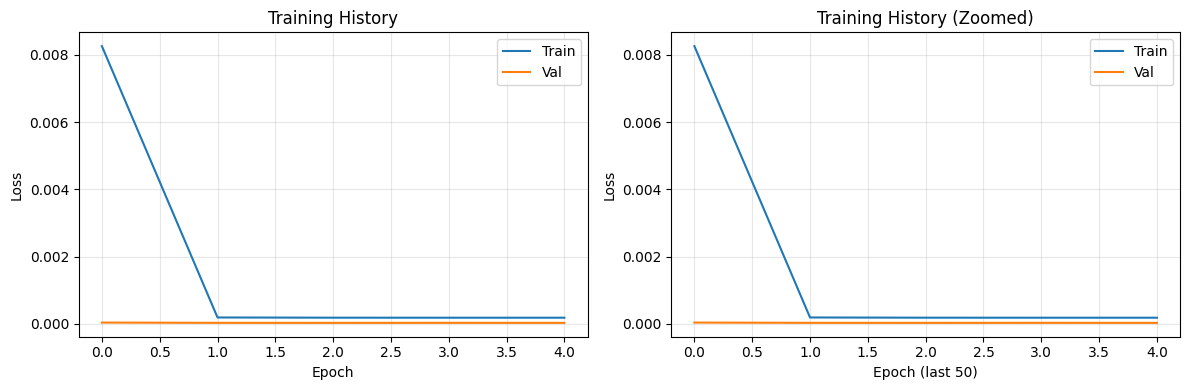

In [20]:
# 训练曲线
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses[-50:], label='Train')
plt.plot(val_losses[-50:], label='Val')
plt.xlabel('Epoch (last 50)')
plt.ylabel('Loss')
plt.title('Training History (Zoomed)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
# 加载最佳模型并评估
model_final.load_state_dict(torch.load('../models/dnn_best.pth'))
model_final.eval()

with torch.no_grad():
    val_pred_scaled = model_final(X_val_t.to(device)).cpu().numpy()

val_pred = target_scaler.inverse_transform(val_pred_scaled).flatten()
y_val_orig = target_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()

rmse = np.sqrt(mean_squared_error(y_val_orig, val_pred))
r2 = r2_score(y_val_orig, val_pred)
corr = np.corrcoef(y_val_orig, val_pred)[0, 1]

print("=" * 50)
print("最终模型验证集评估")
print("=" * 50)
print(f"RMSE: {rmse:.6f}")
print(f"R²: {r2:.6f}")
print(f"Correlation: {corr:.6f}")
print(f"\n预测统计:")
print(f"  Mean: {val_pred.mean():.6f}")
print(f"  Std: {val_pred.std():.6f}")
print(f"  Target Std: {y_val_orig.std():.6f}")

最终模型验证集评估
RMSE: 0.002507
R²: -0.010497
Correlation: 0.003918

预测统计:
  Mean: -0.000239
  Std: 0.000014
  Target Std: 0.002494


## 测试集预测 (使用最佳模型)

In [22]:
# 准备测试数据
train_tail = train_clean.tail(BEST_WINDOW_SIZE + 100).copy()
test_with_history = pd.concat([train_tail, test_featured], ignore_index=True)
test_with_history = test_with_history.fillna(method='ffill').fillna(method='bfill')

# 标准化
X_test_scaled = feature_scaler.transform(test_with_history[feature_cols])

# 创建窗口
X_test_windowed = []
for i in range(BEST_WINDOW_SIZE, len(X_test_scaled)):
    window_features = X_test_scaled[i-BEST_WINDOW_SIZE:i].flatten()
    X_test_windowed.append(window_features)
X_test_windowed = np.array(X_test_windowed)

# 只取测试集部分
n_test = len(test_df)
X_test_windowed = X_test_windowed[-n_test:]

print(f"测试数据形状: {X_test_windowed.shape}")

测试数据形状: (2881, 250)


In [23]:
# 预测
X_test_t = torch.FloatTensor(X_test_windowed).to(device)

model_final.eval()
with torch.no_grad():
    test_pred_scaled = model_final(X_test_t).cpu().numpy()

# 反归一化
test_predictions = target_scaler.inverse_transform(test_pred_scaled).flatten()

print(f"预测数量: {len(test_predictions)}")
print(f"预测均值: {test_predictions.mean():.6f}")
print(f"预测标准差: {test_predictions.std():.6f}")

预测数量: 2881
预测均值: -0.000239
预测标准差: 0.000002


In [24]:
# 生成提交文件
submission_df = pd.DataFrame({
    'Timestamp': test_df['Timestamp'].values[:len(test_predictions)],
    'Prediction': test_predictions
})

submission_file = Path('../submissions/dnn_tuned_submission.csv')
submission_df.to_csv(submission_file, index=False)

print(f"✅ 提交文件已保存: {submission_file}")
print(f"\n预览:")
print(submission_df.head(10))
print(f"\n统计:")
print(submission_df['Prediction'].describe())

✅ 提交文件已保存: ../submissions/dnn_tuned_submission.csv

预览:
            Timestamp  Prediction
0 2025-10-23 23:30:00   -0.000239
1 2025-10-23 23:45:00   -0.000239
2 2025-10-24 00:00:00   -0.000239
3 2025-10-24 00:15:00   -0.000239
4 2025-10-24 00:30:00   -0.000239
5 2025-10-24 00:45:00   -0.000239
6 2025-10-24 01:00:00   -0.000239
7 2025-10-24 01:15:00   -0.000239
8 2025-10-24 01:30:00   -0.000239
9 2025-10-24 01:45:00   -0.000239

统计:
count    2881.000000
mean       -0.000239
std         0.000002
min        -0.000239
25%        -0.000239
50%        -0.000239
75%        -0.000239
max        -0.000195
Name: Prediction, dtype: float64


## 训练模型

In [25]:
# 损失函数和优化器 (论文使用 Adam, lr=0.001)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# 训练参数
EPOCHS = 10
best_val_loss = float('inf')
patience = 3
patience_counter = 0

train_losses = []
val_losses = []

print("开始训练...\n")

开始训练...



In [26]:
for epoch in range(EPOCHS):
    # 训练
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # 验证
    model.eval()
    val_loss = 0
    val_preds = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()
            val_preds.extend(output.cpu().numpy().flatten())
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    # 监控预测标准差
    pred_std = np.std(val_preds)
    
    scheduler.step(val_loss)
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} - Train: {train_loss:.6f} - Val: {val_loss:.6f} - Pred Std: {pred_std:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), '../models/dnn_best.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

print("\n✅ 训练完成!")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x250 and 150x256)

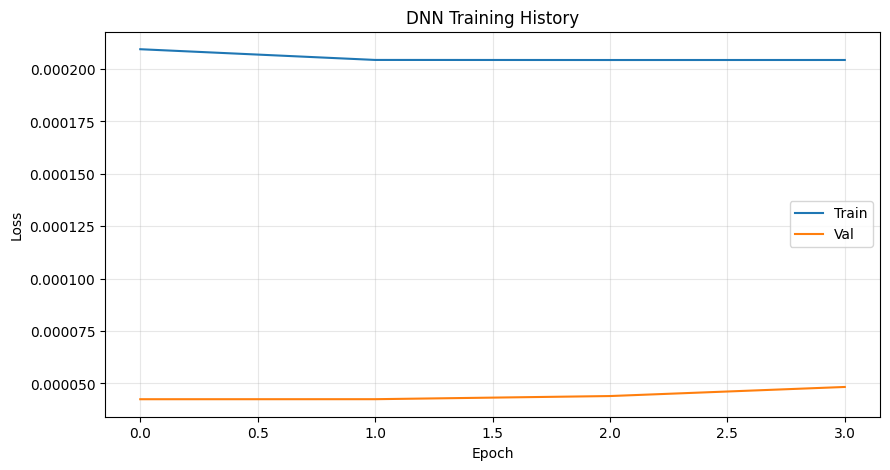

In [ ]:
# 训练曲线
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('DNN Training History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 评估模型

In [ ]:
# 加载最佳模型
model.load_state_dict(torch.load('../models/dnn_best.pth'))
model.eval()

# 验证集预测
with torch.no_grad():
    val_pred_scaled = model(X_val_t.to(device)).cpu().numpy()

# 反归一化
val_pred = target_scaler.inverse_transform(val_pred_scaled).flatten()
y_val_orig = target_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()

# 评估
rmse = np.sqrt(mean_squared_error(y_val_orig, val_pred))
r2 = r2_score(y_val_orig, val_pred)
corr = np.corrcoef(y_val_orig, val_pred)[0, 1]

print(f"验证集评估:")
print(f"  RMSE: {rmse:.6f}")
print(f"  R²: {r2:.6f}")
print(f"  Correlation: {corr:.6f}")
print(f"\n预测统计:")
print(f"  Mean: {val_pred.mean():.6f}")
print(f"  Std: {val_pred.std():.6f}")

验证集评估:
  RMSE: 0.002852
  R²: -0.000177
  Correlation: -0.003127

预测统计:
  Mean: 0.000013
  Std: 0.000029


## 测试集预测

In [ ]:
# 准备测试数据
# 需要训练集尾部数据
train_tail = train_clean.tail(WINDOW_SIZE + 100).copy()

# 合并
test_with_history = pd.concat([train_tail, test_featured], ignore_index=True)
test_with_history = test_with_history.fillna(method='ffill').fillna(method='bfill')

# 标准化
X_test_scaled = feature_scaler.transform(test_with_history[feature_cols])

# 创建窗口
X_test_windowed = []
for i in range(WINDOW_SIZE, len(X_test_scaled)):
    window_features = X_test_scaled[i-WINDOW_SIZE:i].flatten()
    X_test_windowed.append(window_features)
X_test_windowed = np.array(X_test_windowed)

# 只取测试集部分
n_test = len(test_df)
X_test_windowed = X_test_windowed[-n_test:]

print(f"测试数据形状: {X_test_windowed.shape}")

测试数据形状: (2881, 150)


In [ ]:
# 预测
X_test_t = torch.FloatTensor(X_test_windowed).to(device)

model.eval()
with torch.no_grad():
    test_pred_scaled = model(X_test_t).cpu().numpy()

# 反归一化
test_predictions = target_scaler.inverse_transform(test_pred_scaled).flatten()

print(f"预测数量: {len(test_predictions)}")
print(f"预测均值: {test_predictions.mean():.6f}")
print(f"预测标准差: {test_predictions.std():.6f}")

预测数量: 2881
预测均值: -0.000004
预测标准差: 0.000019


## 生成提交文件

In [ ]:
# 创建提交
submission_df = pd.DataFrame({
    'Timestamp': test_df['Timestamp'].values[:len(test_predictions)],
    'Prediction': test_predictions
})

# 保存
submission_dir = Path('../submissions')
submission_dir.mkdir(exist_ok=True)

submission_file = submission_dir / 'dnn_submission.csv'
submission_df.to_csv(submission_file, index=False)

print(f"✅ 提交文件已保存: {submission_file}")
print(f"\n预览:")
print(submission_df.head(10))
print(f"\n统计:")
print(submission_df['Prediction'].describe())

✅ 提交文件已保存: ..\submissions\dnn_submission.csv

预览:
            Timestamp  Prediction
0 2025-10-23 23:30:00   -0.000021
1 2025-10-23 23:45:00   -0.000021
2 2025-10-24 00:00:00   -0.000022
3 2025-10-24 00:15:00   -0.000021
4 2025-10-24 00:30:00   -0.000021
5 2025-10-24 00:45:00   -0.000014
6 2025-10-24 01:00:00   -0.000010
7 2025-10-24 01:15:00   -0.000015
8 2025-10-24 01:30:00   -0.000011
9 2025-10-24 01:45:00   -0.000013

统计:
count    2881.000000
mean       -0.000004
std         0.000019
min        -0.000055
25%        -0.000017
50%        -0.000006
75%         0.000009
max         0.000049
Name: Prediction, dtype: float64


In [ ]:
# 保存模型
model_dir = Path('../models')
torch.save({
    'model_state_dict': model.state_dict(),
    'feature_cols': feature_cols,
    'window_size': WINDOW_SIZE,
}, model_dir / 'dnn_model.pth')

import joblib
joblib.dump(feature_scaler, model_dir / 'dnn_feature_scaler.pkl')
joblib.dump(target_scaler, model_dir / 'dnn_target_scaler.pkl')

print("✅ 模型已保存")

✅ 模型已保存


## 总结

### DNN/MLP 模型架构 (基于论文):
- **Input**: Window_size × N_features (展平的滑动窗口)
- **Hidden Layer 1**: 256 neurons + BatchNorm + ReLU + Dropout
- **Hidden Layer 2**: 128 neurons + BatchNorm + ReLU + Dropout
- **Hidden Layer 3**: 64 neurons + BatchNorm + ReLU + Dropout
- **Output**: 1 (预测值)

### 论文发现:
- MLP 作为基准模型
- LSTM 变体（特别是 BD-LSTM）表现最佳
- 单变量模型通常优于多变量模型